Activate the project

In [1]:
using Pkg
Pkg.activate(".")

  Activating environment at `/media/labfiles/nsom/repos/kp-lflm-group/src/KPpack/Project.toml`


# Load the package KPpack

In [2]:
using KPpack

## test the bulk calculation

In [3]:
material="GaAs"; Temp=0; soc=true;
tipo="KaneII";
#++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

mm=KPpack.Materials(material,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0);
KPpack.ParMat(mm,Temp)
#+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

1.519

In [4]:
kmax= 0.32; Nt=100;
Ktot,Etot=KPpack.calcBandBulk(mm,kmax,Nt,soc,tipo)
#++++++++++++++++++++++++

EDOS, aDOS = KPpack.DOS(-2,2.2,0.01,Etot,0.04);

# Plot band diagram

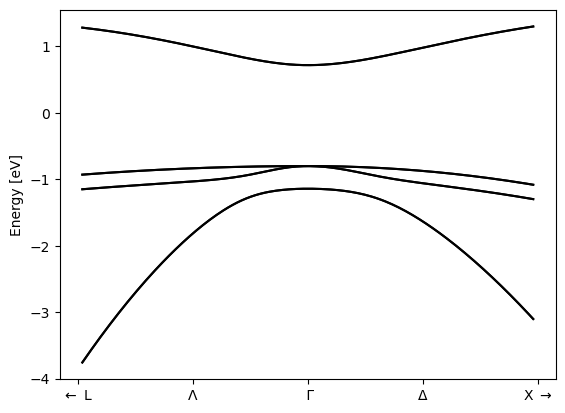

In [5]:
KPpack.PlotBands(Etot,Ktot);

# Plot DOS

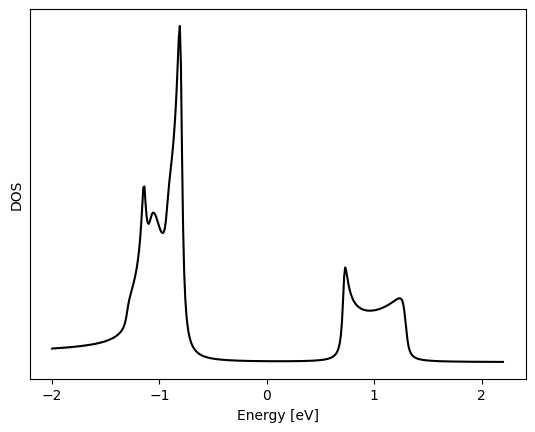

In [6]:
KPpack.PlotDOS(EDOS,aDOS);

# Make a structure

In [7]:
nlayer=5; Npts=110
layer=Array{KPpack.mat}(undef,nlayer)

layer[1]=KPpack.mat("GaAs",70);
layer[2]=KPpack.mat("AlGaAs_0.1",30);
layer[3]=KPpack.mat("GaAs",6);
#layer[4]=KPpack.mat("AlGaAs_0.25",6);
#layer[5]=KPpack.mat("GaAs",6);
layer[4]=KPpack.mat("AlGaAs_0.1",30);
layer[5]=KPpack.mat("GaAs",70);


X,boundary =KPpack.mesh(Npts,layer,nlayer);
mlayer=Array{KPpack.Materials}(undef, length(X));

boundPoints=KPpack.supParams(layer,X,boundary,mlayer,Temp);

# Plot structure

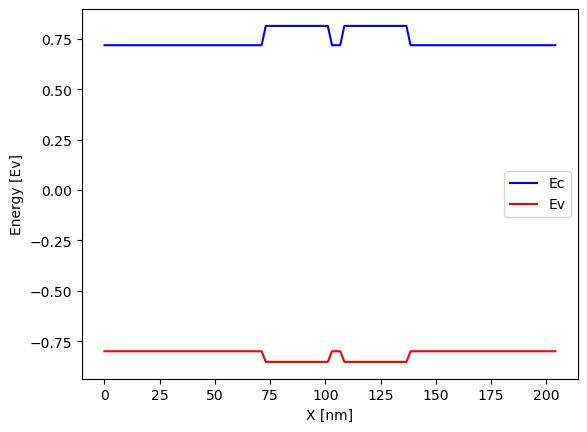

In [8]:
kind="both"
KPpack.plotProf(mlayer,X,kind);

## find eigenvalues solving for K=0

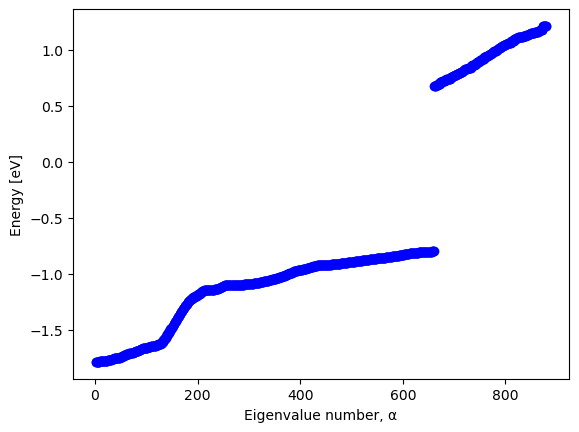

  9.821032 seconds (11.16 M allocations: 1.462 GiB, 4.13% gc time, 55.41% compilation time)


In [9]:
c=0.038; cps=1.0; dx=X[2]-X[1]

@time Eqw0, EVqw0=KPpack.EigSolQW(mlayer,Npts,boundPoints,c,cps,dx);
KPpack.PloteigvQW(Npts,Eqw0);

# QW Band Structure Calculation

In [10]:
kmax= 0.1; Nt=50;
n=8
sV=-0.80; sC=0.5

pl=1; pm=1;
@time Ecq11,Evq11,Kqw11 =KPpack.DiagQWM(mlayer,kmax,Nt,dx,pl,pm,Npts,boundPoints,n,c,cps,sV,sC );

pl=1; pm=0;
@time Ecq10,Evq10,Kqw10 =KPpack.DiagQWM(mlayer,kmax,Nt,dx,pl,pm,Npts,boundPoints,n,c,cps,sV,sC );

 38.993937 seconds (86.38 M allocations: 45.858 GiB, 18.65% gc time, 13.51% compilation time)
 27.462986 seconds (78.19 M allocations: 45.356 GiB, 20.40% gc time, 0.02% compilation time)


## Valence Band 

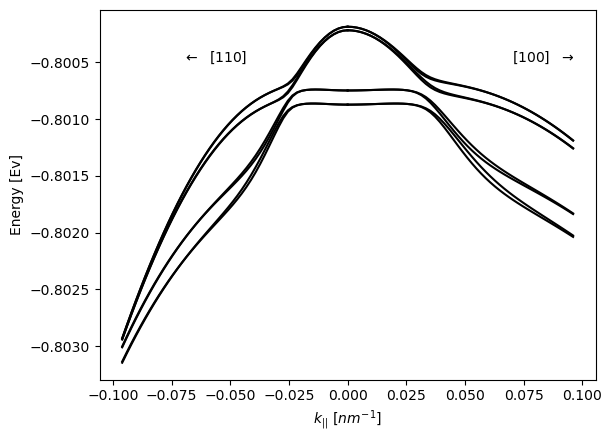

In [11]:
option="complete_V"; poslab=-0.8005
KPpack.PlotQWBand(Ecq11,Evq11,Kqw11,Ecq10,Evq10,Kqw10,option,poslab,kmax);

## Conduction Band

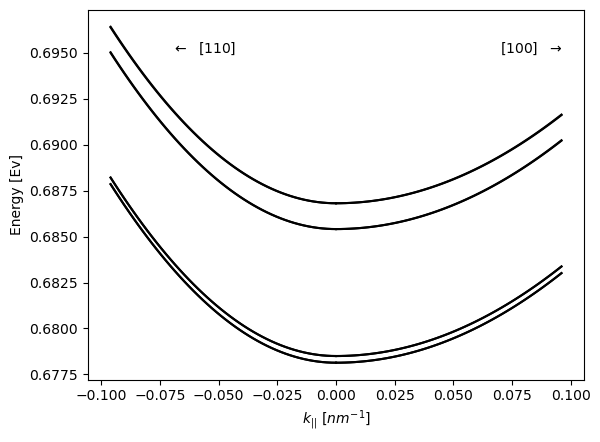

In [12]:
option="complete_C"; poslab=0.695
KPpack.PlotQWBand(Ecq11,Evq11,Kqw11,Ecq10,Evq10,Kqw10,option,poslab,kmax);

# DOS QW

## DOS Valence Band

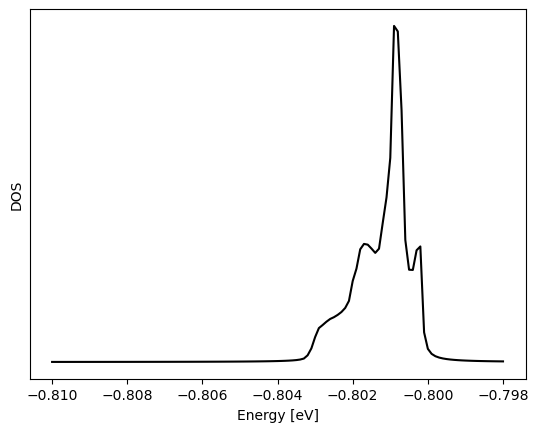

In [13]:
Evqw= vcat(Evq11,Evq10);
EDOSv, aDOSv = KPpack.DOS(-0.81,-0.798,0.0001,Evqw,1e-4);
KPpack.PlotDOS(EDOSv,aDOSv);

## DOS Conduction Band

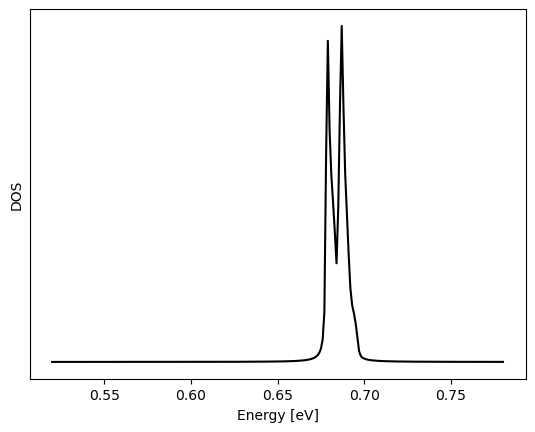

In [14]:
Evqw= vcat(Ecq11,Ecq10);
EDOSc, aDOSc = KPpack.DOS(0.52,0.78,0.001,Evqw,1e-3);
KPpack.PlotDOS(EDOSc,aDOSc);

save a file with band structure

In [15]:
# save a file in folder data with a name given by the user
dat=hcat(Ktot,Etot);
name="BandStructure_GaAs_1"
KPpack.writefile(dat,name)

# Symbolic

In [16]:
using Symbolics

## Model

In [17]:
@variables k₁, k₂,Eg,ħ
@variables m, pₚ,k₃;
k²=k₁^2+k₂^2+k₃^2;
c=ħ^2/2m; cp=ħ/m;

H=[Eg+c*k² 0+im*cp*pₚ*k₁ 0+im*cp*pₚ*k₂ 0+im*cp*pₚ*k₃;
    -im*cp*pₚ*k₁ c*k² 0 0;
    -im*cp*pₚ*k₂ 0 c*k² 0;
    -im*cp*pₚ*k₃ 0 0 c*k²];

## create a Finite differences matrices

In [ ]:
var=k₃ 
H0,H1,H2=KPpack.createKm(H,var); 
A,B,C=KPpack.constructMatrixFD(H0,H1,H2);

In [ ]:
real(A)

In [ ]:
exclude=[k₁; k₂; k₃; ħ]; b1="r"; b2="l"
 PrH=KPpack.getVar(H)
Al,Ar,Bl,Br,Cr,Cl=KPpack.createBmatrizFD(H0,H1,H2,PrH,exclude,b1,b2);
simplify.(imag(Al))

In [ ]:
typeof(real(H[1,1]))

## ++++++++++++++++++++++++++++++++++++String+++++++++++++++++++++

In [ ]:
s="(4*f)/(2*d)"

exxp=KPpack.StrtoSymbConv(s)

In [ ]:
sc="r+i*(c+2c)";
expr=KPpack.StrtoSymbComplexConv(sc)

In [ ]:
imag(expr)

# ++++++++++++++

In [ ]:
model=["E_g+c*(k_x^2+k_y^2+k_z^2)" "i*cp*pₚ*k_x" "i*cp*pₚ*k_y" "i*cp*pₚ*k_z";
    "i*-cp*pₚ*k_x" "c*(k_x^2+k_y^2+k_z^2)" "0" "0";
    "-i*-cp*pₚ*k_y" "0" "c*(k_x^2+k_y^2+k_z^2)" "0";
    "i*-cp*pₚ*k_xz" "0" "0" "c*(k_x^2+k_y^2+k_z^2)"];

strK=["k_x","k_y","k_z"];